In [235]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [236]:
import numpy as np
import pandas as pd

In [237]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [238]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [239]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [240]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [241]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [242]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [243]:
# Create our session (link) from Python to the DB
session=Session(engine)


In [244]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x27225a24f48>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [245]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x272259d9308>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Climate Analysis

In [246]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# First calculate the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date[0]

'2017-08-23'

In [247]:
# Convert the last_date to datetime format
last_date_dt=dt.datetime.strptime(last_date[0],'%Y-%m-%d')
last_date_dt

datetime.datetime(2017, 8, 23, 0, 0)

In [248]:
# Now, we can calculate the date one year ago from our last_date
year_ago=last_date_dt-dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [249]:
# Perform a query to retrieve the data and precipitation scores
precipitation=session.query(Measurement.date, Measurement.prcp)
precipitation[0]

('2010-01-01', 0.08)

In [250]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation)
precipitation_df=precipitation_df.set_index("date")
precipitation_df

,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


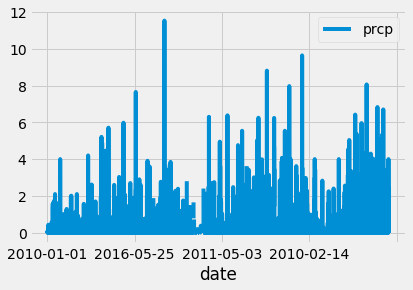

In [251]:
# Sort the dataframe by date
precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.show()

In [252]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df_index.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [253]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [254]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station=station_activity[0].station
most_active_station


'USC00519281'

In [255]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_tobs=session.query(func.min(Measurement.tobs)).all()
max_tobs=session.query(func.max(Measurement.tobs)).all()
avg_tobs=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()
print(f"The lowest temperature recorded is {min_tobs} degrees F")
print(f"The highest temperature recorded is {max_tobs} degrees F")
print(f"The average temperature recorded in the most active station is {avg_tobs} degrees F")

The lowest temperature recorded is [(53.0,)] degrees F
The highest temperature recorded is [(87.0,)] degrees F
The average temperature recorded in the most active station is [(71.66378066378067,)] degrees F


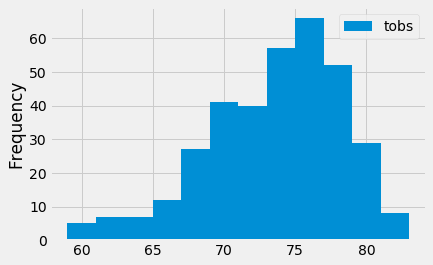

In [256]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_tobs=session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).\
        filter(Measurement.date > year_ago).\
        filter(Measurement.date < last_date_dt).all()
df = pd.DataFrame(active_tobs)
df.plot.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [257]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [258]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_values=(calc_temps(year_ago, last_date_dt))
print(temp_values)

[(58.0, 74.57894736842105, 87.0)]


In [259]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin=temp_values[0][0]
tavg=int(temp_values[0][1])
tmax=temp_values[0][2]
tdiff=tmax-tmin

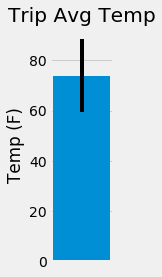

In [260]:
fig, ax = plt.subplots(figsize=(1,4))
ax.bar(x=0,height=tavg,width=1,yerr=tdiff/2)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temp (F)")
ax.set_xticks([])
plt.show()

In [261]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
           
prcp_totals=session.query(Measurement.station, func.sum(Measurement.prcp)).\
            group_by(Measurement.station).\
            filter(Measurement.date >= year_ago).filter(Measurement.date <= last_date_dt).\
            order_by(func.sum(Measurement.prcp).desc()).all()
prcp_totals
prcp_totals_df=pd.DataFrame(prcp_totals, columns=["StationID", "Precipitation"])

In [262]:
# Convert the Stations table to a dataframe
stations_list=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
stations_df=pd.DataFrame(stations_list, columns=["StationID", "Station Name", "Lat", "Long", "Elevation"])


In [263]:
# Merge our Precipitation Total df to the Stations df
pd.merge(prcp_totals_df, stations_df, on="StationID")

,StationID,Precipitation,Station Name,Lat,Long,Elevation
0,USC00516128,147.11,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,68.24,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,48.36,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,37.99,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,33.19,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [264]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
